In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score,confusion_matrix, ConfusionMatrixDisplay, recall_score,classification_report
import os


In [2]:
# Configuración de rutas
base_dir = os.getcwd()
fichero_path = os.path.join(
    base_dir, "..", "data", "processed", "thiroid_cancer_processed.csv"
)


In [3]:
df = pd.read_csv(fichero_path)
df.head(1)

,Age,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,...,Ethnicity_Middle Eastern,Country_China,Country_Germany,Country_India,Country_Japan,Country_Nigeria,Country_Russia,Country_South Korea,Country_UK,Country_USA
0,66,0,1,0,0,0,0,9.37,1.67,6.16,...,0,0,0,0,0,0,1,0,0,0


### Se separan los datos en train y test y se procede a la búsqueda de mejores hiperparámetros 

In [4]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Separar características y etiquetas
X = df[['Age', 'Family_History', 'Radiation_Exposure', 'Iodine_Deficiency',
       'Smoking', 'Obesity', 'Diabetes', 'TSH_Level', 'T3_Level', 'T4_Level',
       'Nodule_Size','Gender_Male', 'Ethnicity_Asian',
       'Ethnicity_Caucasian', 'Ethnicity_Hispanic',
       'Ethnicity_Middle Eastern','Country_China', 'Country_Germany',
       'Country_India', 'Country_Japan', 'Country_Nigeria', 'Country_Russia',
       'Country_South Korea', 'Country_UK', 'Country_USA']]
y = df["Diagnostico"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2517)

# Definir el modelo base
lgb_clf = lgb.LGBMClassifier(objective='binary', boosting_type='gbdt')

# Definir la grilla de parámetros a probar
param_grid = {
    'num_leaves': [7, 11, 15],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1],
    'lambda_l2': [0.01, 0.05],
    'n_estimators': [100]
}

# Definir validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
grid_search = GridSearchCV(estimator=lgb_clf,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv,
                           verbose=1,
                           n_jobs=-1)

# Ajustar el modelo
grid_search.fit(X_train, y_train,
                categorical_feature=['Family_History', 'Radiation_Exposure', 'Iodine_Deficiency',
                                     'Smoking', 'Obesity', 'Diabetes', 'Gender_Male', 'Ethnicity_Asian',
                                     'Ethnicity_Caucasian', 'Ethnicity_Hispanic', 'Ethnicity_Middle Eastern',
                                     'Country_China', 'Country_Germany', 'Country_India', 'Country_Japan',
                                     'Country_Nigeria', 'Country_Russia', 'Country_South Korea',
                                     'Country_UK', 'Country_USA'])

# Mostrar mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Evaluar en test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy en test: {accuracy}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Info] Number of positive: 39597, number of negative: 130555
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1143
[LightGBM] [Info] Number of data points in the train set: 170152, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.232715 -> initscore=-1.193041
[LightGBM] [Info] Start training from score -1.193041
Mejores parámetros encontrados: {'lambda_l2': 0.05, 'learning_rate': 0.1, 'max_depth':

### Se muestra la importancia de cada variable en el modelo para predecir el diagnóstico

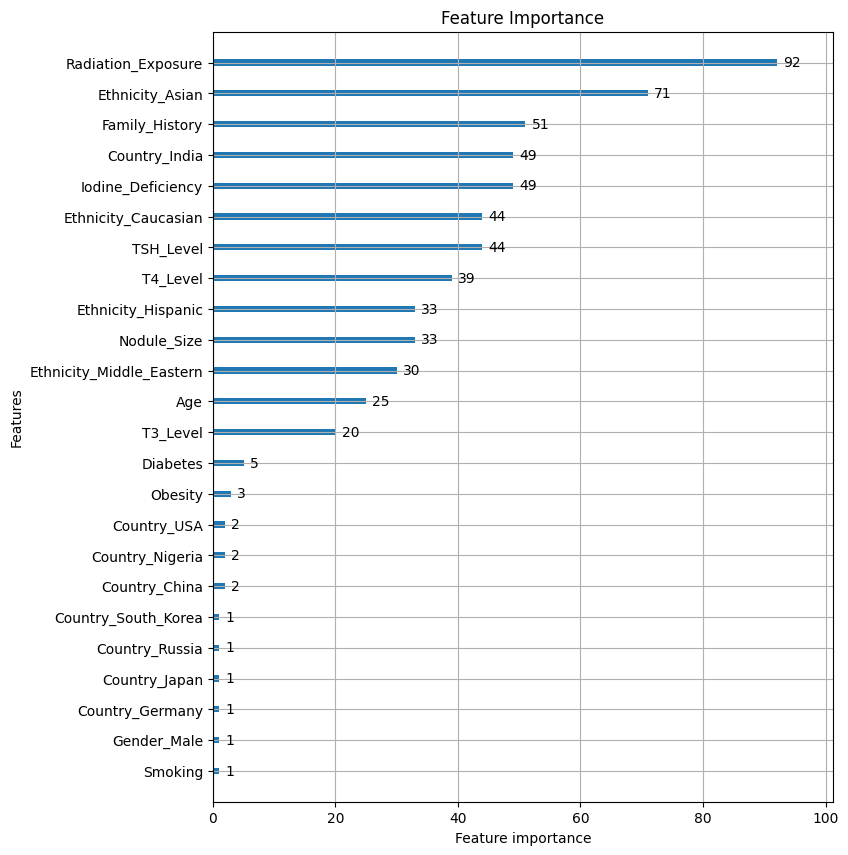

In [5]:
lgb.plot_importance(best_model, figsize=(8, 10))
plt.title("Feature Importance")
plt.show()

### Recal nos muestra de todos los que ha predicho como positivos son realmente positivos

In [9]:
recal = recall_score(y_test, y_pred)
print(f"De los positivos, son en realidad positivos un: {recal}")

De los positivos, son en realidad positivos un: 0.4570620327338856


### Precision nos muestra cuantas de nuestra predicciones positivas son correctas

In [10]:
precision = precision_score(y_test, y_pred)
print(f"De los todos los predichos como positivos, son positivos un: {precision}")

De los todos los predichos como positivos, son positivos un: 0.7013953488372093


### Matriz de confusión cuyos valores son los siguientes: 
### TN FP
### FN TP


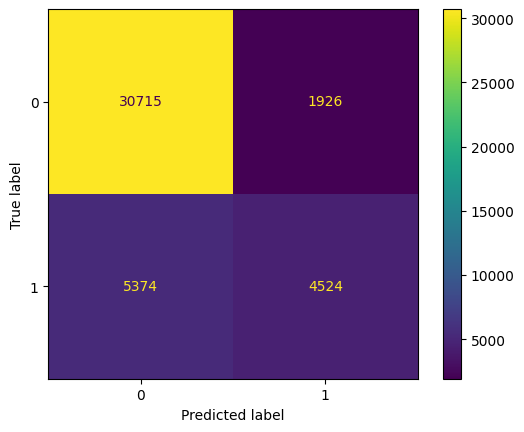

In [8]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

- 5374 son falsos negativos, que equivale a un 12% de todos los detectados como cancer

### Muestra de las distintas métricas tanto en diagnóstico de cáncer como en el que no tiene cáncer:
- Precision
- recal que mide de los positivos cuántos son realmente positivos
- f1-score: es la media entre precision y recal
- support son el número de registro de cada clase en test


In [ ]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=["No Cáncer", "Cáncer"]))



Reporte de Clasificación:
              precision    recall  f1-score   support

   No Cáncer       0.85      0.94      0.89     32641
      Cáncer       0.70      0.46      0.55      9898

    accuracy                           0.83     42539
   macro avg       0.78      0.70      0.72     42539
weighted avg       0.82      0.83      0.81     42539



### Guardar el modelo 

In [9]:
import pickle

# Guardar modelo entrenado en un archivo .pkl
with open("modelo_lightgbm.pkl", "wb") as archivo_salida:
    pickle.dump(best_model, archivo_salida)


